In [ ]:
!pip install torch torch-geometric scikit-learn pandas networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
import numpy
print(numpy.__version__)

2.0.2


In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124


In [ ]:
# Torch-scatter and torch-sparse compatible with torch==2.6.0+cu124
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html -q
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 20.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, random, numpy as np, pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler

# Paths to your datasets
benign_dir = "/content/drive/My Drive/IOT/benign/"
mirai_dir = "/content/drive/My Drive/IOT/mirai/"

# List CSV files
benign_files = os.listdir(benign_dir)
mirai_files = os.listdir(mirai_dir)

# Load and concatenate benign data, parsing Timestamp as datetime
benign_df = pd.concat([
    pd.read_csv(os.path.join(benign_dir, f), parse_dates=['Timestamp']) for f in benign_files
], ignore_index=True)
benign_df['label'] = 0

# Load and concatenate mirai data, parsing Timestamp as datetime
mirai_df = pd.concat([
    pd.read_csv(os.path.join(mirai_dir, f), parse_dates=['Timestamp']) for f in mirai_files
], ignore_index=True)
mirai_df['label'] = 1

# Combine datasets
df = pd.concat([benign_df, mirai_df], ignore_index=True)

print(f"Shape of combined df: {df.shape}")
print("Label counts:\n", df['label'].value_counts())

# Replace infinite values with NaN and drop columns with any NaNs
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(axis=1, how='any')
df = df.fillna(0)

# Separate the Timestamp column (keep it for later)
timestamps = df['Timestamp']

# Separate labels
labels = df['label'].astype(int).values

# Select only numeric columns except 'label' and 'Timestamp' for features
features = df.select_dtypes(include=[np.number]).drop(columns=['label'])

print(f"Feature columns used: {features.columns.tolist()}")

# Scale features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(features)

# Convert to PyTorch tensors
x = torch.tensor(x_scaled, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

print(f"x shape: {x.shape}, y shape: {y.shape}")

# If you need Timestamp back in df for causal sampling or sliding window:
df['Timestamp'] = timestamps

# Now you can proceed with your causal sampling or any time-based logic using df['Timestamp']


<ipython-input-4-2f8a80468b0f>:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv(os.path.join(benign_dir, f), parse_dates=['Timestamp']) for f in benign_files


Shape of combined df: (118284, 85)
Label counts:
 label
0    84526
1    33758
Name: count, dtype: int64
Feature columns used: ['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST 

In [ ]:
num_nodes = x.shape[0]
edges = [[i, i + 1] for i in range(num_nodes - 1)]
edges += [[i + 1, i] for i in range(num_nodes - 1)]  # bidirectional

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
print(f"Total nodes: {num_nodes}, edges: {edge_index.size(1)}")
# Create a PyG Data object
from torch_geometric.data import Data

data = Data(x=x, y=y, edge_index=edge_index)

# Save the data object to disk
torch.save(data, "/content/drive/My Drive/IOT/iot_data_graph.pth")
print("✅ Data object saved to /content/iot_data_graph.pth")


Total nodes: 118284, edges: 236566
✅ Data object saved to /content/iot_data_graph.pth


Epoch 01 - Loss: 0.7332, Acc: 45.90%
Epoch 02 - Loss: 2.8137, Acc: 72.41%
Epoch 03 - Loss: 4.3425, Acc: 75.03%
Epoch 04 - Loss: 1.9124, Acc: 61.93%
Epoch 05 - Loss: 1.2102, Acc: 46.99%
Epoch 06 - Loss: 1.5586, Acc: 65.27%
Epoch 07 - Loss: 1.1618, Acc: 75.75%
Epoch 08 - Loss: 0.7940, Acc: 70.37%
Epoch 09 - Loss: 0.7852, Acc: 71.48%
Epoch 10 - Loss: 0.8094, Acc: 78.71%
Epoch 11 - Loss: 0.7006, Acc: 77.18%
Epoch 12 - Loss: 0.7570, Acc: 71.65%
Epoch 13 - Loss: 0.7607, Acc: 74.52%
Epoch 14 - Loss: 0.6016, Acc: 75.20%
Epoch 15 - Loss: 0.6909, Acc: 81.10%

--- Test Classification Report ---
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     16905
           1       0.63      0.83      0.71      6752

    accuracy                           0.81     23657
   macro avg       0.77      0.82      0.79     23657
weighted avg       0.84      0.81      0.82     23657



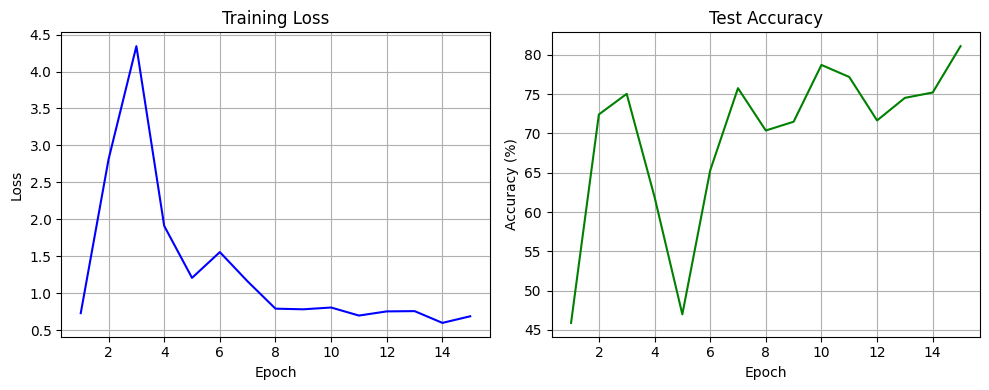

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume x, edge_index, y, num_nodes are already defined

# Create train/test masks
indices = np.arange(num_nodes)
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y.numpy(), random_state=42)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, verbose=False):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = out.argmax(dim=1)
    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = preds[data.test_mask].cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    if verbose:
        print("\n--- Test Classification Report ---")
        print(classification_report(y_true, y_pred, zero_division=0))
    return acc

in_channels = data.num_features
hidden_channels = 128
out_channels = len(torch.unique(data.y))

class_counts = pd.Series(y.numpy()).value_counts().sort_index()
class_weights = torch.tensor(
    [len(y) / (len(class_counts) * class_counts[i]) for i in class_counts.index],
    dtype=torch.float
)

model = GraphSAGE(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

epochs = 15
losses, accuracies = [], []

for epoch in range(1, epochs + 1):
    loss = train(model, data, optimizer, criterion)
    acc = evaluate(model, data)
    losses.append(loss)
    accuracies.append(acc * 100)
    print(f"Epoch {epoch:02d} - Loss: {loss:.4f}, Acc: {acc*100:.2f}%")

# Print detailed report only once after training
evaluate(model, data, verbose=True)

# Plot loss and accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), losses, label='Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracies, label='Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import torch

num_nodes = data.num_nodes
train_mask = data.train_mask

# Create validation mask (randomly select 10% of training nodes)
train_indices = train_mask.nonzero(as_tuple=False).view(-1)
num_val = int(0.1 * train_indices.size(0))
val_indices = train_indices[torch.randperm(train_indices.size(0))[:num_val]]

val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[val_indices] = True

# Update data object
data.val_mask = val_mask

# Optional: update train_mask to exclude validation nodes
new_train_mask = train_mask.clone()
new_train_mask[val_indices] = False
data.train_mask = new_train_mask


Starting training...
Epoch 001, Loss: 0.6558, Val Acc: 0.7004
Epoch 010, Loss: 0.3528, Val Acc: 0.8534
Epoch 020, Loss: 0.2506, Val Acc: 0.9095
Epoch 030, Loss: 0.2127, Val Acc: 0.9273
Epoch 040, Loss: 0.1863, Val Acc: 0.9393
Epoch 050, Loss: 0.1731, Val Acc: 0.9398
Epoch 060, Loss: 0.1576, Val Acc: 0.9486
Epoch 070, Loss: 0.1599, Val Acc: 0.9550
Epoch 080, Loss: 0.1413, Val Acc: 0.9565
Epoch 090, Loss: 0.1338, Val Acc: 0.9590
Epoch 100, Loss: 0.1355, Val Acc: 0.9593
Epoch 110, Loss: 0.1260, Val Acc: 0.9606
Epoch 120, Loss: 0.1203, Val Acc: 0.9620
Early stopping triggered at Epoch 127 due to no improvement for 10 epochs.

Training finished. Loading best model for final evaluation.

--- Evaluation Results ---
Accuracy:  0.9612
Precision: 0.9611
Recall:    0.9612
F1 Score:  0.9611


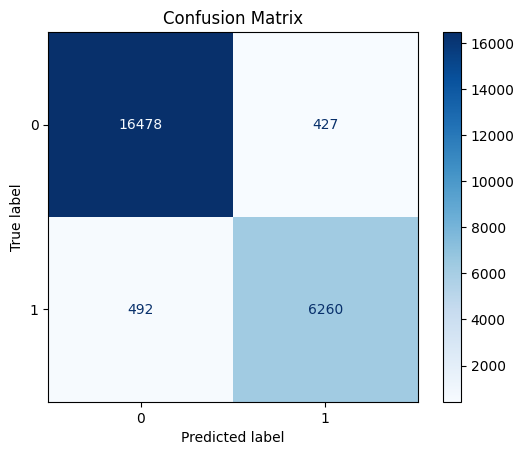

NameError: name 'roc_curve' is not defined

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
# from torch_geometric.data import DataLoader # Not used in this snippet
from torch.optim.lr_scheduler import StepLR # Not explicitly used for scheduler in loop but imported

# --- Add this if you want to save/load to/from Google Drive in Colab ---
# from google.colab import drive
# drive.mount('/content/drive')
# ---------------------------------------------------------------------

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout_rate = 0.5 # Renamed to avoid confusion with F.dropout p argument

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training) # Use self.dropout_rate

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training) # Use self.dropout_rate

        x = self.lin(x)
        return x

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        probs = F.softmax(out, dim=1)

        test_mask = data.test_mask
        y_true = data.y[test_mask].cpu().numpy()
        y_pred = probs[test_mask].argmax(dim=1).cpu().numpy()
        y_probs = probs[test_mask].cpu().numpy()

    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
    from sklearn.preprocessing import label_binarize
    import matplotlib.pyplot as plt
    import numpy as np

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n--- Evaluation Results ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False) # Typically, confusion matrix doesn't need grid
    plt.show()

    n_classes = probs.shape[1]
    # For multiclass ROC, micro-average is often used, but ensure shapes match
    # label_binarize will create one-hot encoded true labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Ensure y_true_bin and y_probs have the same shape for roc_curve with ravel()
    # This check is usually only needed if data preprocessing has inconsistencies.
    # For standard classification, if n_classes matches, shapes should align.
    if y_true_bin.shape != y_probs.shape:
        print("Warning: Shape mismatch between y_true_bin and y_probs. Adjusting samples.")
        min_samples = min(y_true_bin.shape[0], y_probs.shape[0])
        y_true_bin = y_true_bin[:min_samples]
        y_probs = y_probs[:min_samples]


    # For multiclass ROC, using .ravel() flattens all true/prob values into 1D arrays
    # This creates a 'micro-averaged' ROC curve, treating all (class, sample) pairs equally.
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', lw=1) # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Averaged ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# --- Placeholder for 'data' object. You need to define or load your 'data' here ---
# Example:
# from torch_geometric.datasets import Planetoid
# dataset = Planetoid(root='/tmp/Cora', name='Cora')
# data = dataset[0]
# ---------------------------------------------------------------------------------

# Hyperparameters
in_channels = data.num_node_features
hidden_channels = 128
out_channels = int(data.y.max()) + 1 # number of classes

model = GraphSAGE(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Define the path to save the model.
# Option A: Save in current directory
MODEL_SAVE_PATH = "iot_model.pt"
# Option B: Save to Google Drive (if mounted)
MODEL_SAVE_PATH = "/content/drive/My Drive/IOT/iot_model.pth"


# Training loop with early stopping
best_val_acc = 0 # Renamed for clarity from best_acc to best_val_acc
patience = 10
counter = 0

print("Starting training...")
for epoch in range(1, 201):
    loss = train(model, data, optimizer, criterion)

    # Evaluate validation accuracy more frequently, e.g., every epoch or every few epochs
    # For plotting loss/accuracy curves, it's better to evaluate every epoch.
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        preds = out[data.val_mask].argmax(dim=1)
        labels = data.y[data.val_mask]
        val_acc = (preds == labels).sum().item() / labels.size(0)

    # Print status less frequently to avoid spamming console, e.g., every 10 epochs
    if epoch % 10 == 0 or epoch == 1: # Print first epoch as well
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping logic
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0 # Reset patience counter
        torch.save(model.state_dict(), MODEL_SAVE_PATH) # Save the best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at Epoch {epoch} due to no improvement for {patience} epochs.")
            break

print("\nTraining finished. Loading best model for final evaluation.")

# Load the best model's state dictionary
# Make sure the path here matches where you saved it.
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Evaluate the model on the test set
evaluate_model(model, data)

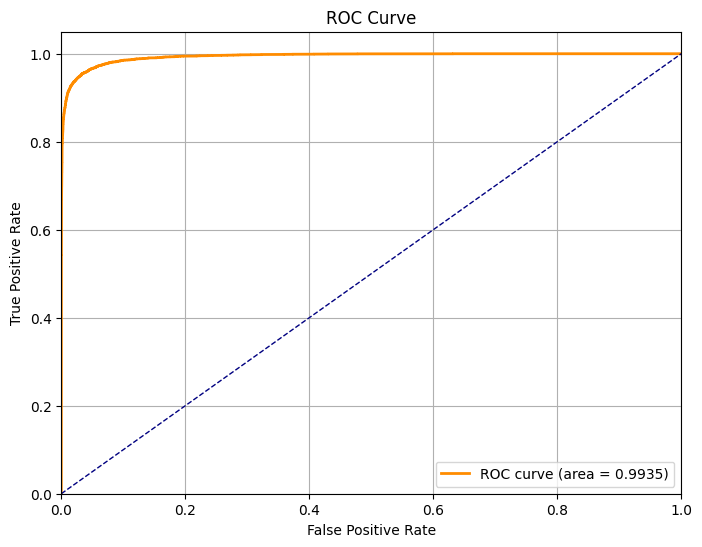

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn.functional as F

def plot_roc_curve(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        probs = F.softmax(out, dim=1)

    test_mask = data.test_mask
    y_true = data.y[test_mask].cpu().numpy()
    y_probs = probs[test_mask].cpu().numpy()

    # If binary classification: probs.shape[1] == 2
    if y_probs.shape[1] == 2:
        # Use probability for positive class (class 1)
        y_scores = y_probs[:, 1]
    else:
        # If only one output neuron (rare for classification, but check)
        y_scores = y_probs[:, 0]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Call this:
plot_roc_curve(model, data)
